In [1]:
#!/usr/bin/python3
from binance.client import Client
from time import time
import pickle as pickle
from datetime import datetime
import pandas as pd
import pandas_ta as ta
from pycaret.classification import load_model, predict_model

import random


def get_client():
    fn = '../../key/binance-key.pickle'
    # fn = '/home/era/key/binance-key.pickle'
    with open(fn, 'rb') as handle:
        k = pickle.load(handle)
    return Client(k['API_KEY'], k['API_SECRET'])


client = get_client()


def get_unix_timestamp(date_string):
    """
    Converts the input date string to Unix timestamp.

    Parameters:
        date_string (str): Input date string in the format "dd/mm/yyyy hh:mm:ss".

    Returns:
        int: Unix timestamp of the given date.
    """
    try:
        date_obj = datetime.strptime(date_string, "%d/%m/%Y %H:%M:%S")
        timestamp = int(date_obj.timestamp())
        return timestamp
    except ValueError:
        print("Invalid date format. Please use the format 'dd/mm/yyyy hh:mm:ss'.")
        return None

def get_historical_data(start_timestamp, end_timestamp, coin_pair): 
    data = []
    tot = (end_timestamp - start_timestamp)/(900*500)
    cntr = 0
    for current_sts in range(start_timestamp, end_timestamp+1, 900*500):
        next_ets = current_sts + 900*500 if (current_sts + 900*500) < end_timestamp else end_timestamp
        print(current_sts, next_ets, f'100% completed') if next_ets == end_timestamp else print(current_sts, next_ets, f'{round(cntr*100/tot, 1)}% completed')
        cntr += 1
        # Futures market
        klines = client.futures_historical_klines(coin_pair, '15m', current_sts*1000, next_ets*1000, limit=500)
        # Spot market
        # klines = client.get_historical_klines(coin_pair, interval, current_sts*1000, next_ets*1000, limit=500)
        
        for kline in klines:
            timestamp = kline[0]/1000
            open_price = float(kline[1])
            high_price = float(kline[2])
            low_price = float(kline[3])
            close_price = float(kline[4])
            volume = float(kline[5])

            data.append([timestamp, open_price, high_price, low_price, close_price, volume])

    df = pd.DataFrame(data, columns=['time', 'open', 'high', 'low', 'close', 'volume'])
    # df.to_csv(f'/home/ubuntu/data/{coin_pair}-{interval}.csv', index=False)
    # print('Data Exported')
    print(f'Historical Data of {coin_pair} Downloaded')
    return df

def generate_features(start_timestamp, end_timestamp, coin_pair):
    df = get_historical_data(start_timestamp, end_timestamp, coin_pair)
    candlestick_frame = 12
    pnl_threshold = 3


    # df = pd.read_csv('/home/ubuntu/data/ETHUSDT-15m.csv')
    try:
        df.ta.strategy("all")
    except Exception as e:
        print(e)
        ts = list(df['time'])
        open = list(df['open'])
        high = list(df['high'])
        low = list(df['low'])
        close = list(df['close'])
        volume = list(df['volume'])
        tot = len(ts)
        long_runup_lst = []
        long_drawdown_lst = []
        short_runup_lst = []
        short_drawdown_lst = []

        for idx in range(tot):
            if (idx >= candlestick_frame) and (idx <= tot - candlestick_frame):
                max_high = max(high[idx+1:idx+candlestick_frame])
                min_low = min(low[idx+1:idx+candlestick_frame])
                entry_price = open[idx+1]
                long_runup_lst.append(round((max_high*100/entry_price)-100, 6))
                long_drawdown_lst.append(round((min_low*100/entry_price)-100, 6))
                short_runup_lst.append(round((entry_price*100/min_low)-100, 6))
                short_drawdown_lst.append(round((entry_price*100/max_high)-100, 6))
            else:
                long_runup_lst.append(0)
                long_drawdown_lst.append(0)
                short_runup_lst.append(0)
                short_drawdown_lst.append(0)     


        long=[]
        short=[]
        dont_trade=[]
        signal = []

        for idx in range(tot):
            if (idx >= candlestick_frame) and (idx <= tot - candlestick_frame):
                if long_runup_lst[idx] >= pnl_threshold:
                    signal.append('long')
                elif short_runup_lst[idx] >= pnl_threshold:
                    signal.append('short')
                else:
                    signal.append('dont_trade')
            else:
                signal.append('dont_trade')

        df['coin'] = [coin_pair]*len(signal)
        df['signal'] = signal

        long_indices = df[df['signal'].str.contains('long', case=False)].index
        short_indices = df[df['signal'].str.contains('short', case=False)].index
        dont_trade_indices = list(df[df['signal'].str.contains('dont_trade', case=False)].index)
        num_indices_to_pick  = len(dont_trade_indices) - min([len(long_indices), len(short_indices)])
        random_indices = random.sample(dont_trade_indices, num_indices_to_pick)
        df = df.drop(random_indices)

        df.reset_index(drop=True, inplace=True)

        df = df.drop(columns = ['time', 'open', 'high', 'low', 'close', 'volume'], axis=1)
        dataset_fn = f'../../data/{coin_pair}-dataset.csv'
        pd.DataFrame(df).to_csv(dataset_fn, index=False)
        print(f'{coin_pair} Features Generated and saved')


In [ ]:
coins_list = ['BTC', 'ETH', 'BNB', 'XRP', 'ADA', 'DOGE', 'SOL', 'TRX', 'DOT', 'MATIC', 'LTC', 'BCH', 'AVAX', 'XLM', 'LINK', 'UNI', 'XMR', 'ATOM', 'ETC', 'HBAR', 'ICP', 'FIL', 'LDO', 'APT', 'ARB', 'QNT', 'VET', 'NEAR', 'OP', 'MKR', 'GRT', 'AAVE', 'ALGO', 'AXS', 'EGLD', 'STX', 'SAND', 'XTZ', 'EOS', 'INJ', 'THETA', 'IMX', 'SNX', 'MANA', 'FTM', 'RUNE', 'APE', 'RNDR', 'NEO', 'KAVA', 'FLOW', 'CHZ', 'GALA', 'KLAY', 'SUI', 'FXS', 'ZEC', 'CFX', 'CRV', 'MINA', 'COMP', 'GMX', 'DYDX', 'WOO', 'ASTR']
for i in range(len(coins_list)):
    coin_pair = f'{coins_list[i]}USDT'
    print('working on', coin_pair)
    start_timestamp = get_unix_timestamp('1/1/2016 00:00:00')
    end_timestamp = int(time())
    generate_features(start_timestamp, end_timestamp, coin_pair)
    


In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd

dataset_path = '../../data/'
all_datasets = [f for f in listdir(dataset_path) if isfile(join(dataset_path, f))]
can_be_used_for_training = []
for fn in all_datasets:
    df = pd.read_csv(f'{dataset_path}{fn}')
    dont_trade_count = list(df['signal']).count('dont_trade')
    if dont_trade_count >= 9000:
        can_be_used_for_training.append(fn)

In [ ]:
import pandas as pd
from pycaret.classification import *
from pycaret.classification import ClassificationExperiment
from lightgbm import LGBMClassifier


def train_model(coin_feaure):
    exp = ClassificationExperiment()
    data = pd.read_csv(f'../../data/{coin_feaure}')
    s = setup(data, target = 'signal', session_id = 123, use_gpu=True)
    best = create_model(LGBMClassifier(), return_train_score=True)
    validation_scores = pull()
    accuracy_mean = validation_scores['Accuracy']['CV-Val']['Mean']

    # save pipeline
    model_name = coin_feaure.split('-')[0]
    save_model(best, f'../../models/{model_name}-{accuracy_mean}')
    print(f'{model_name} model saved. accuracy_mean={accuracy_mean}')

coin_feaures = ['MATICUSDT-dataset.csv', 'EOSUSDT-dataset.csv', 'COMPUSDT-dataset.csv', 'DOGEUSDT-dataset.csv', 'MKRUSDT-dataset.csv', 'VETUSDT-dataset.csv', 'FILUSDT-dataset.csv', 'GALAUSDT-dataset.csv', 'LTCUSDT-dataset.csv', 'BCHUSDT-dataset.csv', 'SANDUSDT-dataset.csv', 'SOLUSDT-dataset.csv', 'DYDXUSDT-dataset.csv', 'FTMUSDT-dataset.csv', 'XLMUSDT-dataset.csv', 'UNIUSDT-dataset.csv', 'GRTUSDT-dataset.csv', 'LINKUSDT-dataset.csv', 'XTZUSDT-dataset.csv', 'SNXUSDT-dataset.csv', 'ZECUSDT-dataset.csv', 'AXSUSDT-dataset.csv', 'AVAXUSDT-dataset.csv', 'ADAUSDT-dataset.csv', 'EGLDUSDT-dataset.csv', 'ATOMUSDT-dataset.csv', 'MANAUSDT-dataset.csv', 'KAVAUSDT-dataset.csv', 'XRPUSDT-dataset.csv', 'NEOUSDT-dataset.csv', 'CHZUSDT-dataset.csv', 'ETCUSDT-dataset.csv', 'DOTUSDT-dataset.csv', 'RUNEUSDT-dataset.csv', 'ALGOUSDT-dataset.csv', 'AAVEUSDT-dataset.csv', 'NEARUSDT-dataset.csv', 'CRVUSDT-dataset.csv', 'THETAUSDT-dataset.csv', 'HBARUSDT-dataset.csv']

for i in range(len(coin_feaures)):
    train_model(coin_feaures[i])


In [1]:
import pandas as pd


coin_feaures = ['MATICUSDT-dataset.csv', 'EOSUSDT-dataset.csv', 'COMPUSDT-dataset.csv', 'DOGEUSDT-dataset.csv', 'MKRUSDT-dataset.csv', 'VETUSDT-dataset.csv', 'FILUSDT-dataset.csv', 'GALAUSDT-dataset.csv', 'LTCUSDT-dataset.csv', 'BCHUSDT-dataset.csv', 'SANDUSDT-dataset.csv', 'SOLUSDT-dataset.csv', 'DYDXUSDT-dataset.csv', 'FTMUSDT-dataset.csv', 'XLMUSDT-dataset.csv', 'UNIUSDT-dataset.csv', 'GRTUSDT-dataset.csv', 'LINKUSDT-dataset.csv', 'XTZUSDT-dataset.csv', 'SNXUSDT-dataset.csv', 'ZECUSDT-dataset.csv', 'AXSUSDT-dataset.csv', 'AVAXUSDT-dataset.csv', 'ADAUSDT-dataset.csv', 'EGLDUSDT-dataset.csv', 'ATOMUSDT-dataset.csv', 'MANAUSDT-dataset.csv', 'KAVAUSDT-dataset.csv', 'XRPUSDT-dataset.csv', 'NEOUSDT-dataset.csv', 'CHZUSDT-dataset.csv', 'ETCUSDT-dataset.csv', 'DOTUSDT-dataset.csv', 'RUNEUSDT-dataset.csv', 'ALGOUSDT-dataset.csv', 'AAVEUSDT-dataset.csv', 'NEARUSDT-dataset.csv', 'CRVUSDT-dataset.csv', 'THETAUSDT-dataset.csv', 'HBARUSDT-dataset.csv']
dfs=[]
dataset_path = '../../data/'

for fn in coin_feaures:
    dfs.append(pd.read_csv(f'{dataset_path}{fn}'))

concatenated_df = pd.concat(dfs, ignore_index=True)  # Set ignore_index=True to reset index
pd.DataFrame(concatenated_df).to_csv(f'{dataset_path}combined_dataset.csv', index=False)


In [6]:
import pandas as pd
from pycaret.classification import *
from pycaret.classification import ClassificationExperiment
from lightgbm import LGBMClassifier


def train_model():
    exp = ClassificationExperiment()
    data = concatenated_df
    s = setup(data, target = 'signal', session_id = 123, use_gpu=True)
    best = create_model(LGBMClassifier(), return_train_score=True)
    validation_scores = pull()
    accuracy_mean = validation_scores['Accuracy']['CV-Val']['Mean']

    # save pipeline
    model_name = 'combined_model'
    save_model(best, f'../../models/{model_name}-{accuracy_mean}')
    print(f'{model_name} model saved. accuracy_mean={accuracy_mean}')

train_model()

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1


[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


,Description,Value
0,Session id,123
1,Target,signal
2,Target type,Multiclass
3,Target mapping,"dont_trade: 0, long: 1, short: 2"
4,Original data shape,"(1678255, 211)"
5,Transformed data shape,"(1678255, 211)"
6,Transformed train set shape,"(1174778, 211)"
7,Transformed test set shape,"(503477, 211)"
8,Numeric features,209
9,Categorical features,1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


Transformation Pipeline and Model Successfully Saved
combined_model model saved. accuracy_mean=0.8603


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


,Description,Value
0,Session id,123
1,Target,signal
2,Target type,Multiclass
3,Target mapping,"dont_trade: 0, long: 1, short: 2"
4,Original data shape,"(1678255, 211)"
5,Transformed data shape,"(1678255, 211)"
6,Transformed train set shape,"(1174778, 211)"
7,Transformed test set shape,"(503477, 211)"
8,Numeric features,209
9,Categorical features,1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


Transformation Pipeline and Model Successfully Loaded


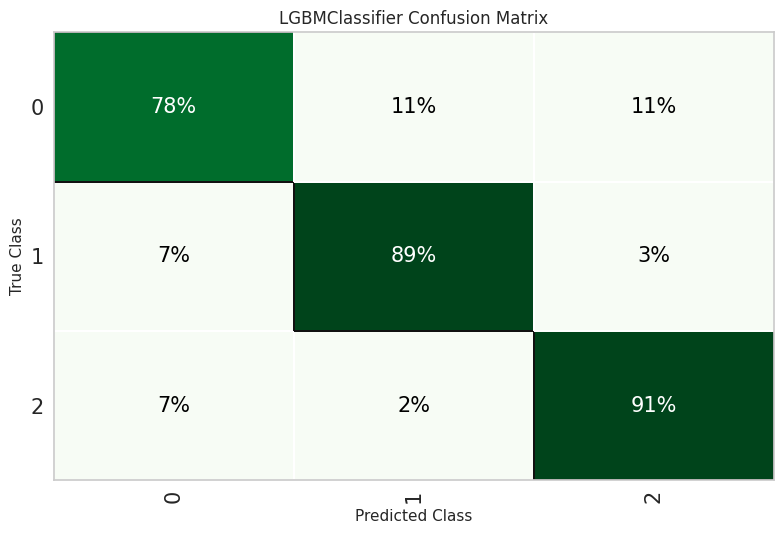

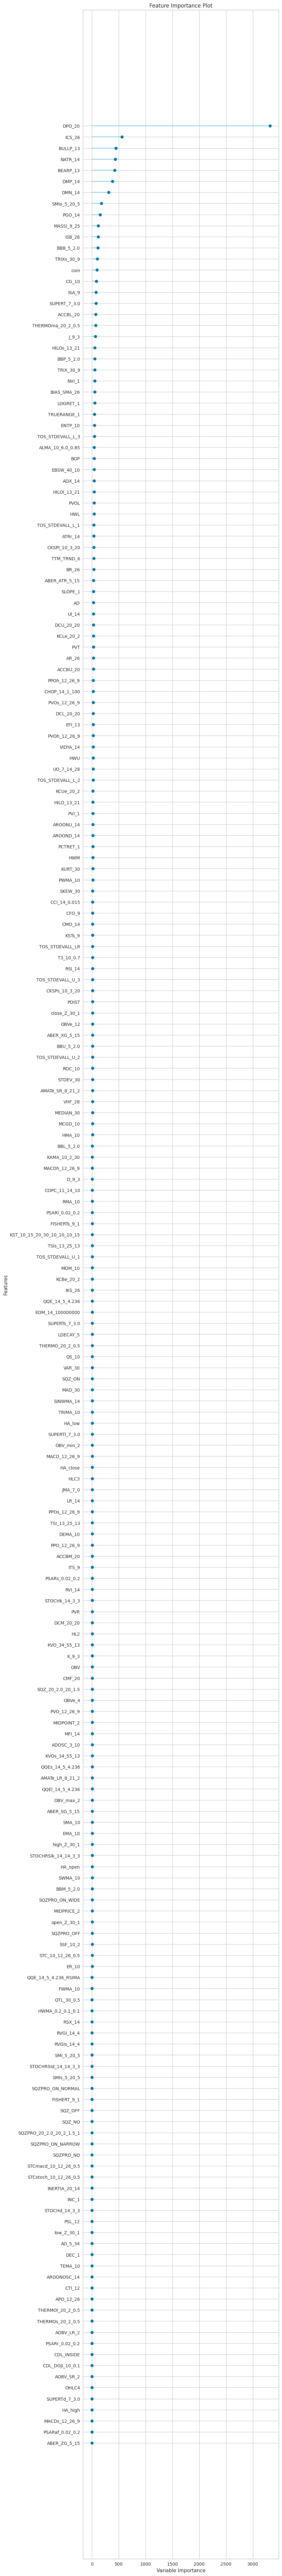

In [12]:
from pycaret.classification import load_model, predict_model
import pandas as pd

data = pd.read_csv('../../data/combined_dataset.csv')
s = setup(data, target = 'signal', session_id = 123, use_gpu=True)

# Load trained Pipeline
model_name = 'combined_model-0.8603'
model = load_model(f'../../models/{model_name}')
plot_model(model, plot = 'confusion_matrix', plot_kwargs = {'percent': True})
plot_model(model, plot = 'feature_all')